In [2]:
# temp_rf.py
# Avery Krieger 11/2022, adapted components from Tim Currier and Max Turner

# argumenmts: [1] date (yyyy-mm-dd); [2] series_number; [3] roi_set_name
# implementation: save_strfs.py 2022-03-17 1 roi_set_postfrom visanalysis.analysis import imaging_data, shared_analysis

import os
from pathlib import Path

import matplotlib.patches as mpatches  # for the legend patches
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem
from scipy import interpolate
from two_photon_analysis import medulla_analysis as ma
from visanalysis.analysis import imaging_data, shared_analysis
from matplotlib.ticker import FixedLocator, FixedFormatter


def plotEachROIRawSpecificCellType(ID, roi_data, alt_pre_time, 
                                   dff, df, experiment_file_name, 
                                   series_number, roi_set_name):

    time_vector, epoch_response = ma.getAltEpochResponseMatrix(ID, np.vstack(roi_data['roi_response']), alt_pre_time=alt_pre_time, dff=dff, df=df)
    roi_number = len(roi_data['roi_response'])

    roi_number = roi_data["epoch_response"].shape[0]
    # copy from plotConditionedROIResponses
    fh, ax = plt.subplots(roi_number, 1, figsize=(25, 25*roi_number))
    color = plt.cm.tab20(np.linspace(0, 1, roi_number))
    end_time = np.ceil(roi_data['time_vector'][-1]) + 1
    x_locator = FixedLocator(list(range(-1, 16)))

    #[x.set_ylim([-0.55, +1.6]) for x in ax.ravel()] # list comprehension makes each axis have the same limit for comparisons
    for roi_ind in range(roi_number):
        query = {'opto_stim': False}
        # For no opto condition
        no_opto_trials = shared_analysis.filterTrials(epoch_response, ID, query=query)
        noOptoMean = np.mean(no_opto_trials[roi_ind, :, :], axis=0)
        nopt_sem_plus = noOptoMean + sem(no_opto_trials[roi_ind, :, :], axis=0)
        nopt_sem_minus = noOptoMean - sem(no_opto_trials[roi_ind, :, :], axis=0)
        ax[roi_ind].plot(roi_data['time_vector'],
            noOptoMean, color='m', alpha=1.0)
        ax[roi_ind].fill_between(roi_data['time_vector'],
            nopt_sem_plus, nopt_sem_minus, color=color[roi_ind], alpha=0.8)

        query = {'opto_stim': True}
        # For no opto condition
        opto_trials = shared_analysis.filterTrials(epoch_response, ID, query=query)
        optoMean = np.mean(opto_trials[roi_ind, :, :], axis=0)
        opto_sem_plus = optoMean + sem(opto_trials[roi_ind, :, :], axis=0)
        opto_sem_minus = optoMean - sem(opto_trials[roi_ind, :, :], axis=0)
        ax[roi_ind].plot(roi_data['time_vector'],
            optoMean, color='k', alpha=0.9)
        ax[roi_ind].fill_between(roi_data['time_vector'],
            opto_sem_plus, opto_sem_minus, color='g', alpha=0.6)
        ax[roi_ind].set_title(f'{experiment_file_name} Series: {series_number} {roi_set_name} | ROI: {roi_ind}', fontsize=20)
        #ax[roi_ind].set_title(f'ROI:{roi_ind}', fontsize=20)

        # axes fuckery
        #ax[roi_ind].xaxis.grid(True)
        ax[roi_ind].grid(axis="x", color="k", alpha=.3, linewidth=2, linestyle=":")
        ax[roi_ind].xaxis.set_major_locator(x_locator)
        ax[roi_ind].tick_params(axis="x", direction="in", length=16, width=2, color="turquoise")
        ax[roi_ind].grid(axis="y", color="k", alpha=.5, linewidth=.5)


    if savefig == True:
        fh.savefig(
            save_directory
            + "RawTraces."
            + str(experiment_file_name)
            + ".Series "
            + str(series_number)
            + "."
            + str(roi_set_name)
            + ".pdf",
            dpi=300,
        )
        
def plotAcrossROIRawSpecificCellType(ID, roi_data, alt_pre_time, 
                                   dff, df, experiment_file_name, 
                                   series_number, roi_set_name):

    time_vector, epoch_response = ma.getAltEpochResponseMatrix(ID, np.vstack(roi_data['roi_response']), alt_pre_time=alt_pre_time, dff=dff, df=df)
    roi_number = len(roi_data['roi_response'])

    #initialize:
    len_trial = len(roi_data['time_vector'])
    ROI_no_opto_trials = np.empty(shape=[0, len_trial])
    ROI_no_opto_sem_plus = np.empty(shape=[0, len_trial])
    ROI_no_opto_sem_minus = np.empty(shape=[0, len_trial])
    ROI_yes_opto_trials = np.empty(shape=[0, len_trial])
    ROI_yes_opto_sem_plus = np.empty(shape=[0, len_trial])
    ROI_yes_opto_sem_minus = np.empty(shape=[0, len_trial])
    
    #[x.set_ylim([-0.55, +1.6]) for x in ax.ravel()] # list comprehension makes each axis have the same limit for comparisons
    for roi_ind in range(roi_number):
        query = {'opto_stim': False}
        # For no opto condition
        no_opto_trials = shared_analysis.filterTrials(epoch_response, ID, query=query)
        noOptoMean = np.mean(no_opto_trials[roi_ind, :, :], axis=0)
        nopt_sem_plus = noOptoMean + sem(no_opto_trials[roi_ind, :, :], axis=0)
        nopt_sem_minus = noOptoMean - sem(no_opto_trials[roi_ind, :, :], axis=0)

        query = {'opto_stim': True}
        # For no opto condition
        opto_trials = shared_analysis.filterTrials(epoch_response, ID, query=query)
        optoMean = np.mean(opto_trials[roi_ind, :, :], axis=0)
        opto_sem_plus = optoMean + sem(opto_trials[roi_ind, :, :], axis=0)
        opto_sem_minus = optoMean - sem(opto_trials[roi_ind, :, :], axis=0)

        ROI_no_opto_trials = np.append(ROI_no_opto_trials, [noOptoMean], axis = 0)  
        ROI_no_opto_sem_plus = np.append(ROI_no_opto_sem_plus, [nopt_sem_plus], axis = 0)
        ROI_no_opto_sem_minus = np.append(ROI_no_opto_sem_minus, [nopt_sem_minus], axis = 0)
        ROI_yes_opto_trials = np.append(ROI_yes_opto_trials, [optoMean], axis = 0)
        ROI_yes_opto_sem_plus = np.append(ROI_yes_opto_sem_plus, [opto_sem_plus], axis = 0)
        ROI_yes_opto_sem_minus = np.append(ROI_yes_opto_sem_minus, [opto_sem_minus], axis = 0)
    
    # Some averaging!
    mean_ROI_no_opto_trials = np.mean(ROI_no_opto_trials, axis = 0)
    mean_ROI_no_opto_sem_plus = np.mean(ROI_no_opto_sem_plus, axis = 0)
    mean_ROI_no_opto_sem_minus = np.mean(ROI_no_opto_sem_minus, axis = 0)
    mean_ROI_yes_opto_trials = np.mean(ROI_yes_opto_trials, axis = 0)
    mean_ROI_yes_opto_sem_plus = np.mean(ROI_yes_opto_sem_plus, axis = 0)
    mean_ROI_yes_opto_sem_minus = np.mean(ROI_yes_opto_sem_minus, axis = 0)
    total_ROI_count = ROI_no_opto_trials.shape[0]
    
    # The actual plotting part
    
    # copy from plotConditionedROIResponses
    fh, ax = plt.subplots(1, 1, figsize=(25, 10))
    end_time = np.ceil(roi_data['time_vector'][-1]) + 1
    x_locator = FixedLocator(list(range(-1, 16)))


    ax.plot(roi_data['time_vector'],
        mean_ROI_no_opto_trials, color='g', alpha=1.0)
    ax.fill_between(roi_data['time_vector'],
        mean_ROI_no_opto_sem_plus, mean_ROI_no_opto_sem_minus, color='g', alpha=0.8)
        
    ax.plot(roi_data['time_vector'],
            mean_ROI_yes_opto_trials, color='r', alpha=0.9)
    ax.fill_between(roi_data['time_vector'],
        mean_ROI_yes_opto_sem_plus, mean_ROI_yes_opto_sem_minus, color='r', alpha=0.6)
    ax.set_title(f'{experiment_file_name} Series: {series_number} {roi_set_name} | ROI Count: {total_ROI_count}', fontsize=20)

    #ax.axhline(y=0, color='k', alpha=0.5)
    ax.axvline(x=2, color='turquoise')

    
    # axes fuckery
    #ax[roi_ind].xaxis.grid(True)
    ax.grid(axis="x", color="k", alpha=.3, linewidth=2, linestyle=":")
    ax.xaxis.set_major_locator(x_locator)
    ax.tick_params(axis="x", direction="in", length=16, width=2, color="turquoise")
    ax.grid(axis="y", color="k", alpha=.5, linewidth=.5)
        
    if savefig == True:
        fh.savefig(
            save_directory
            + "AcrossROIsRawTraces."
            + str(experiment_file_name)
            + ".Series "
            + str(series_number)
            + "."
            + str(roi_set_name)
            + "."
            + "ROI Count = "
            + str(total_ROI_count)
            + ".pdf",
            dpi=300,
        )

def collapseROIsResponsesAcrossExperiments(expts):
    # Going to collect the difference between no opto and opto b/c there isn't a great way to normalize
    # This will let me compare across trials
    
    #initialize:
    # This bit is just to get the len_trial parameter
    file_path = os.path.join(expts[0, 0], expts[0, 1] + ".hdf5")
    ID = imaging_data.ImagingDataObject(file_path, expts[0, 2], quiet=False)
    roi_data = ID.getRoiResponses(expts[0, 3])
    len_trial = len(roi_data['time_vector'])
    
    # This must be initialized to append the np.array
    ROI_no_opto_trials = np.empty(shape=[0, len_trial])
    ROI_no_opto_sem_plus = np.empty(shape=[0, len_trial])
    ROI_no_opto_sem_minus = np.empty(shape=[0, len_trial])
    ROI_yes_opto_trials = np.empty(shape=[0, len_trial])
    ROI_yes_opto_sem_plus = np.empty(shape=[0, len_trial])
    ROI_yes_opto_sem_minus = np.empty(shape=[0, len_trial])
    
    # Loop through experiments 
    for exp in range(0, len(expts)):
        print(f'-------Started Experiment {exp+1} of {len(expts)}!-------\n')
        file_path = os.path.join(expts[exp, 0], expts[exp, 1] + ".hdf5")
        ID = imaging_data.ImagingDataObject(file_path, expts[exp, 2], quiet=False)
        roi_data = ID.getRoiResponses(expts[exp, 3])
        
        time_vector, epoch_response = ma.getAltEpochResponseMatrix(ID, np.vstack(roi_data['roi_response']), dff=dff, df=df)
        roi_number = len(roi_data['roi_response'])

        for roi_ind in range(roi_number):
            query = {'opto_stim': False}
            # For no opto condition
            no_opto_trials = shared_analysis.filterTrials(epoch_response, ID, query=query)
            noOptoMean = np.mean(no_opto_trials[roi_ind, :, :], axis=0)
            nopt_sem_plus = noOptoMean + sem(no_opto_trials[roi_ind, :, :], axis=0)
            nopt_sem_minus = noOptoMean - sem(no_opto_trials[roi_ind, :, :], axis=0)

            query = {'opto_stim': True}
            # For no opto condition
            opto_trials = shared_analysis.filterTrials(epoch_response, ID, query=query)
            optoMean = np.mean(opto_trials[roi_ind, :, :], axis=0)
            opto_sem_plus = optoMean + sem(opto_trials[roi_ind, :, :], axis=0)
            opto_sem_minus = optoMean - sem(opto_trials[roi_ind, :, :], axis=0)

            ROI_no_opto_trials = np.append(ROI_no_opto_trials, [noOptoMean], axis = 0)  
            ROI_no_opto_sem_plus = np.append(ROI_no_opto_sem_plus, [nopt_sem_plus], axis = 0)
            ROI_no_opto_sem_minus = np.append(ROI_no_opto_sem_minus, [nopt_sem_minus], axis = 0)
            ROI_yes_opto_trials = np.append(ROI_yes_opto_trials, [optoMean], axis = 0)
            ROI_yes_opto_sem_plus = np.append(ROI_yes_opto_sem_plus, [opto_sem_plus], axis = 0)
            ROI_yes_opto_sem_minus = np.append(ROI_yes_opto_sem_minus, [opto_sem_minus], axis = 0)

#     # Some averaging!
#     mean_ROI_no_opto_trials = np.mean(ROI_no_opto_trials, axis = 0)
#     mean_ROI_no_opto_sem_plus = np.mean(ROI_no_opto_sem_plus, axis = 0)
#     mean_ROI_no_opto_sem_minus = np.mean(ROI_no_opto_sem_minus, axis = 0)
#     mean_ROI_yes_opto_trials = np.mean(ROI_yes_opto_trials, axis = 0)
#     mean_ROI_yes_opto_sem_plus = np.mean(ROI_yes_opto_sem_plus, axis = 0)
#     mean_ROI_yes_opto_sem_minus = np.mean(ROI_yes_opto_sem_minus, axis = 0)
    total_ROI_count = ROI_no_opto_trials.shape[0]
    
    return (ROI_no_opto_trials, ROI_no_opto_sem_plus, ROI_no_opto_sem_minus,
            ROI_yes_opto_trials, ROI_yes_opto_sem_plus, ROI_yes_opto_sem_minus, 
            total_ROI_count

           )

# Functions for plotting and collapsing

In [ ]:
# Mi1 Experiments
mi1_exp0 = [["/Volumes/ROG2TBAK/data/bruker/20221025", "2022-10-25", "1", "Mi1_proximal_mixed"]]
mi1_exp1 = [["/Volumes/ROG2TBAK/data/bruker/20221025", "2022-10-25", "1", "Mi1_proximal_big_opto_response"]]
mi1_exp2 = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "3", "Mi1_proximal_mixed"]]
mi1_exp3 = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "5", "Mi1_proximal_mixed"]]

expts = np.concatenate(
                       (mi1_exp0, mi1_exp1, mi1_exp2, mi1_exp3, 
                       axis = 0
                      )

save_directory = "/Volumes/ROG2TBAK/data/bruker/raw_specific_cell_types/" #+ experiment_file_name + "/"
Path(save_directory).mkdir(exist_ok=True)
# initialize variables
alt_pre_time = 1
df = False
dff = False
saveFig = True

a1, b1, c1, a2, b2, c2, d = collapseResponsesAcrossExperiments(expts)

In [ ]:
# L2 Experiments
l2_exp0 = [["/Volumes/ROG2TBAK/data/bruker/20221101", "2022-11-01", "2", "L2_modulated"]]
l2_exp1 = [["/Volumes/ROG2TBAK/data/bruker/20221101", "2022-11-01", "6", "L2_modulated"]]

expts = np.concatenate(
                       (l2_exp0, l2_exp1), 
                       axis = 0
                      )

In [23]:
# Mi1 Experiments
mi1_exp1_prox = [["/Volumes/ROG2TBAK/data/bruker/20221025", "2022-10-25", "2", "Mi1_proximal"]]
mi1_exp1_medi = [["/Volumes/ROG2TBAK/data/bruker/20221025", "2022-10-25", "2", "Mi1_medial"]]
mi1_exp1_dist = [["/Volumes/ROG2TBAK/data/bruker/20221025", "2022-10-25", "2", "Mi1_distal"]]

mi1_exp2_prox = [["/Volumes/ROG2TBAK/data/bruker/20221025", "2022-10-25", "5", "Mi1_proximal"]]
mi1_exp2_medi = [["/Volumes/ROG2TBAK/data/bruker/20221025", "2022-10-25", "5", "Mi1_medial"]]
mi1_exp2_dist = [["/Volumes/ROG2TBAK/data/bruker/20221025", "2022-10-25", "5", "Mi1_distal"]]

mi1_exp3_prox = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "1", "Mi1_proximal"]]
mi1_exp3_medi = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "1", "Mi1_medial"]]
mi1_exp3_dist = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "1", "Mi1_distal"]]

mi1_exp4_prox = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "3", "Mi1_proximal"]]
mi1_exp4_medi = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "3", "Mi1_medial"]]
mi1_exp4_dist = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "3", "Mi1_distal"]]

mi1_exp5_prox = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "5", "Mi1_proximal"]]
mi1_exp5_medi = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "5", "Mi1_medial"]]
mi1_exp5_dist = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "5", "Mi1_distal"]]

expts_prox = np.concatenate(
                       (#mi1_exp0_prox, 
                        mi1_exp1_prox, mi1_exp2_prox,
                        mi1_exp3_prox, mi1_exp4_prox, mi1_exp5_prox), 
                        axis = 0,
                      )
expts_medi = np.concatenate(
                       (#mi1_exp0_medi, 
                        mi1_exp1_medi, mi1_exp2_medi,
                        mi1_exp3_medi, mi1_exp4_medi, mi1_exp5_medi), 
                        axis = 0,
                      )
expts_dist = np.concatenate(
                       (#mi1_exp0_dist, 
                        mi1_exp1_dist, mi1_exp2_dist,
                        mi1_exp3_dist, mi1_exp4_dist, mi1_exp5_dist), 
                        axis = 0,
                      )
single_roi = True

expts = expts_prox

/Volumes/ROG2TBAK/data/bruker/raw_specific_cell_types/
-------Started Experiment 1 of 5!-------

===================TIMING: Channel 0======================
150 Stims presented (of 150 parameterized)
Stim start to start: [min=14.026, median=14.059, max=14.085] / parameterized = 14.000 sec
Stim duration: [min=9.976, median=9.992, max=10.009] / parameterized = 10.000 sec
Dropped 0 / 180000 frames (0.00%)
===================TIMING: Channel 1======================
150 Stims presented (of 150 parameterized)
Stim start to start: [min=14.026, median=14.051, max=14.085] / parameterized = 14.000 sec
Stim duration: [min=9.976, median=9.992, max=10.009] / parameterized = 10.000 sec
Dropped 0 / 180002 frames (0.00%)
Warnging: Size mismatch idx = 26
===================TIMING: Channel 0======================
150 Stims presented (of 150 parameterized)
Stim start to start: [min=14.026, median=14.059, max=14.085] / parameterized = 14.000 sec
Stim duration: [min=9.976, median=9.992, max=10.009] / paramet

TypeError: 'AxesSubplot' object is not subscriptable

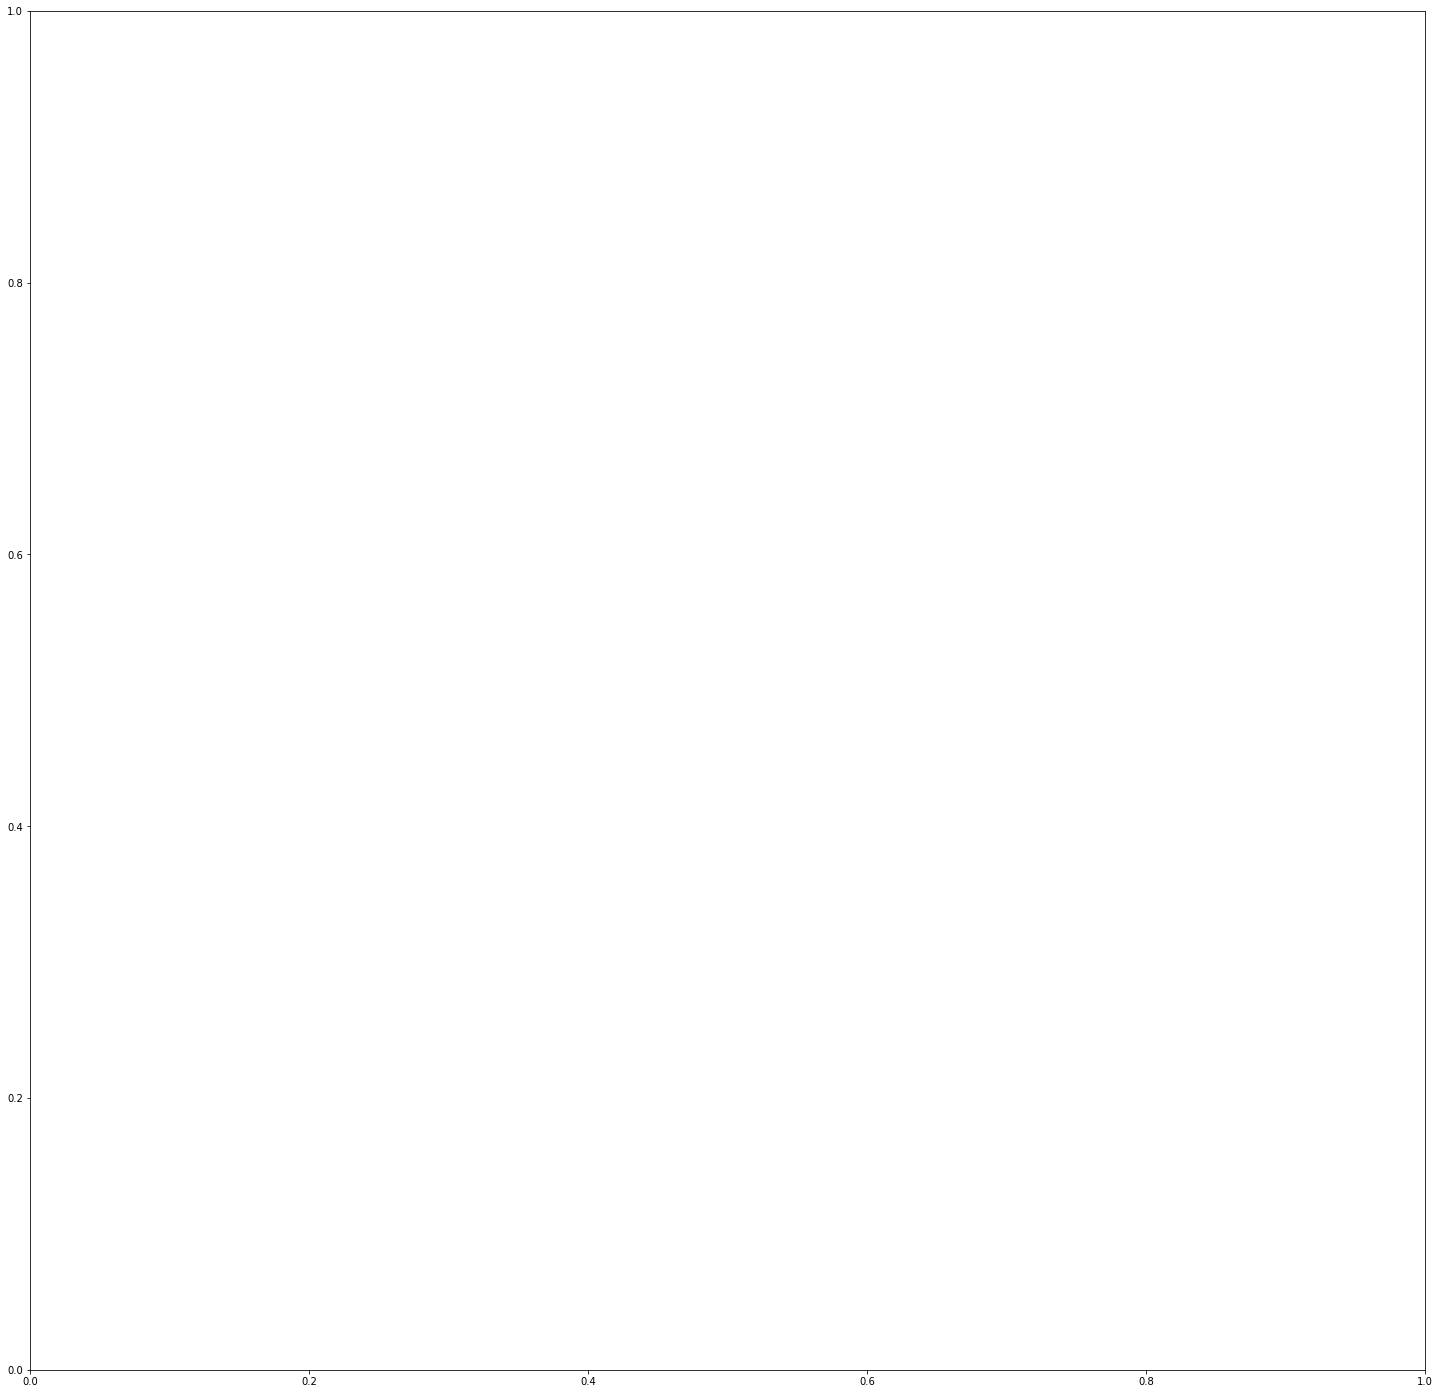

In [9]:
# Plotting each ROI for all expts:

save_directory = "/Volumes/ROG2TBAK/data/bruker/raw_specific_cell_types/" #+ experiment_file_name + "/"
print(save_directory)
Path(save_directory).mkdir(exist_ok=True)
# initialize variables
alt_pre_time = 1
df = False
dff = False
saveFig = True

# Loop through experiments and plot it
for exp in range(0, len(expts)):
    print(f'-------Started Experiment {exp+1} of {len(expts)}!-------\n')
    file_path = os.path.join(expts[exp, 0], expts[exp, 1] + ".hdf5")
    ID = imaging_data.ImagingDataObject(file_path, expts[exp, 2], quiet=False)
    roi_data = ID.getRoiResponses(expts[exp, 3])
    
    plotEachROIRawSpecificCellType(ID, roi_data, alt_pre_time, 
                                   dff, df, experiment_file_name = expts[exp,1], 
                                   series_number = expts[exp,2], roi_set_name = expts[exp,3])

/Volumes/ROG2TBAK/data/bruker/raw_specific_cell_types/
-------Started Experiment 1 of 5!-------

Warnging: Size mismatch idx = 26
Warnging: Size mismatch idx = 26
-------Started Experiment 2 of 5!-------

Warnging: Size mismatch idx = 63
Warnging: Size mismatch idx = 63
-------Started Experiment 3 of 5!-------

-------Started Experiment 4 of 5!-------

-------Started Experiment 5 of 5!-------



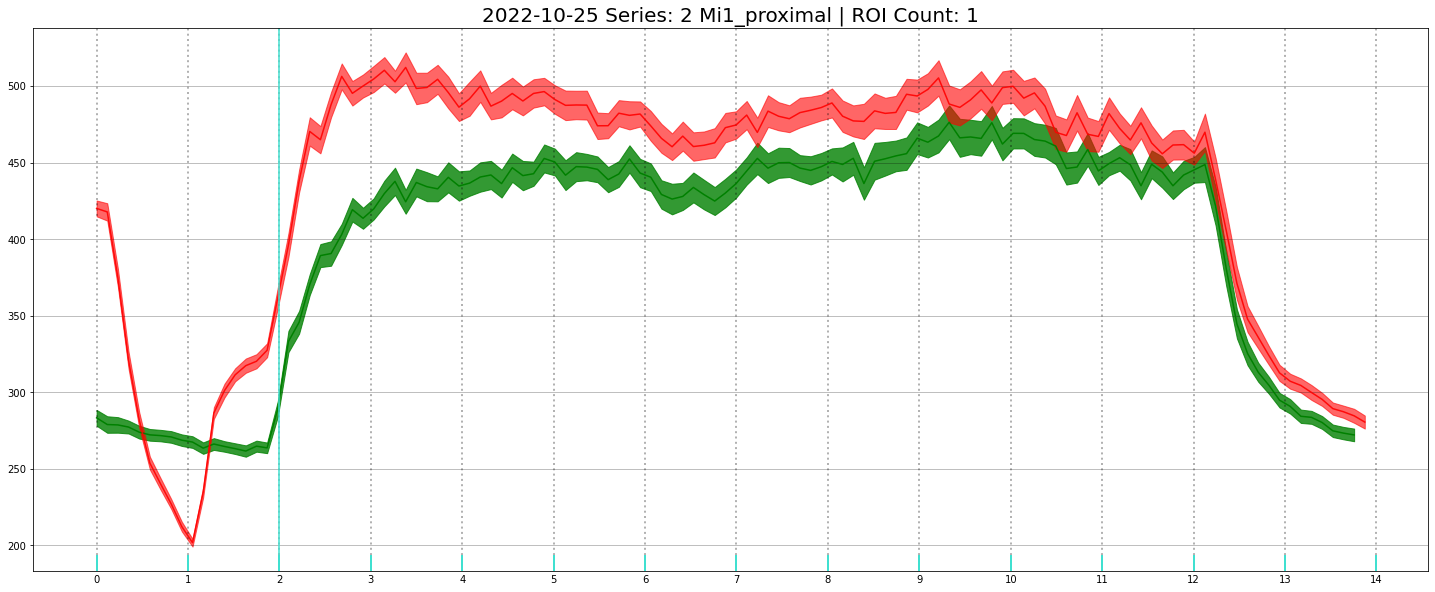

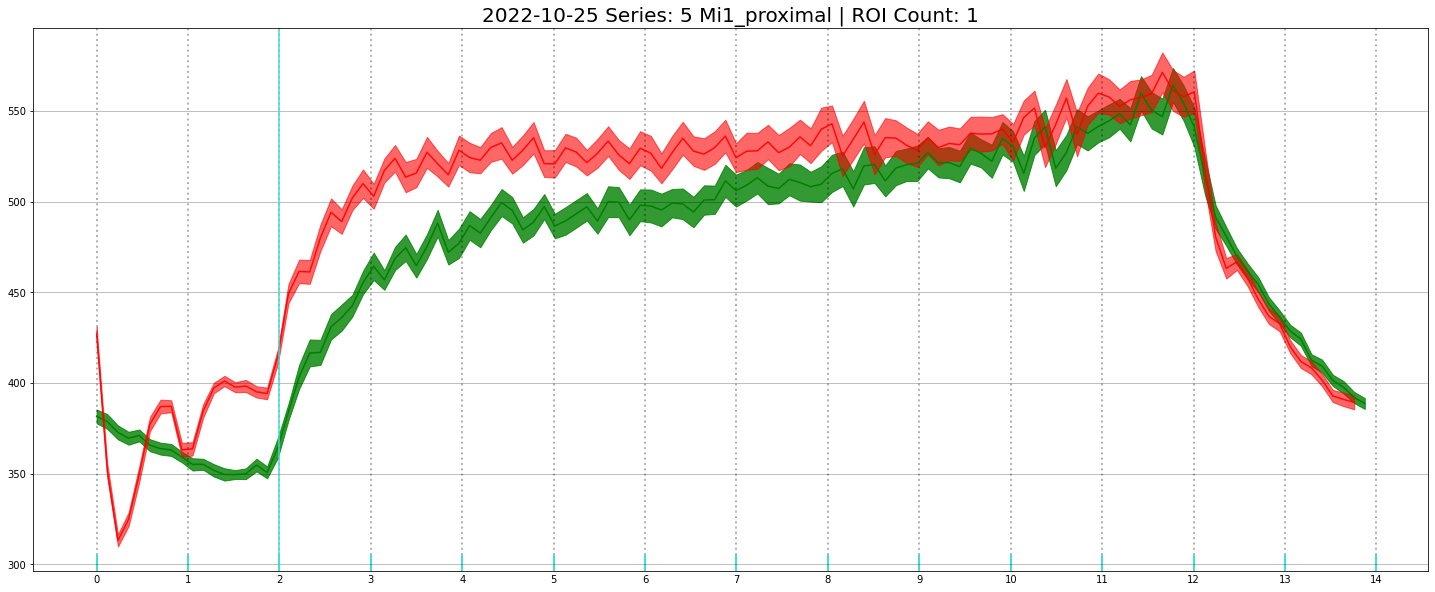

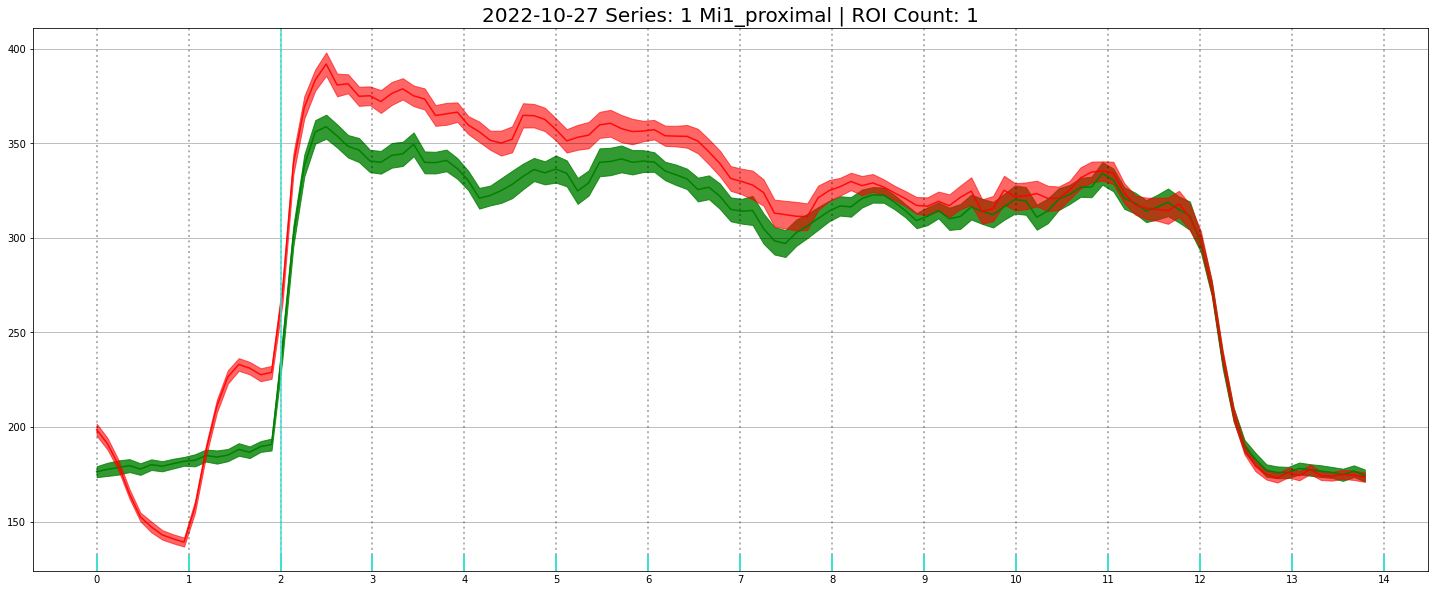

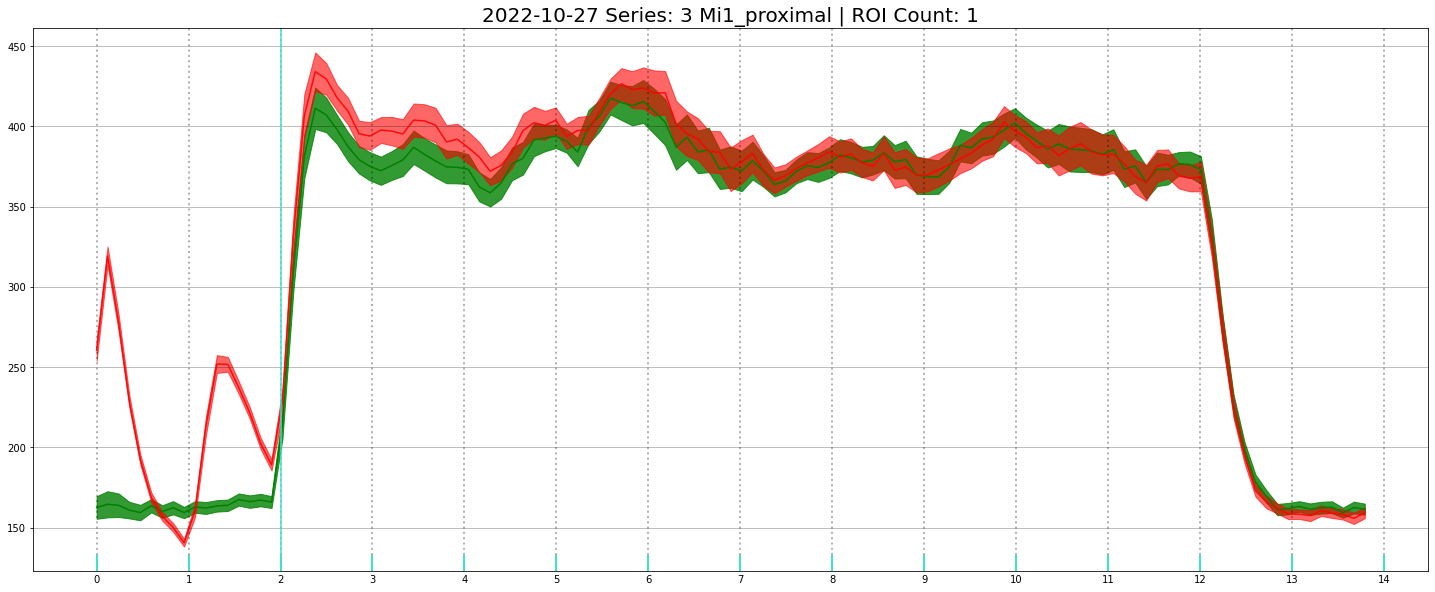

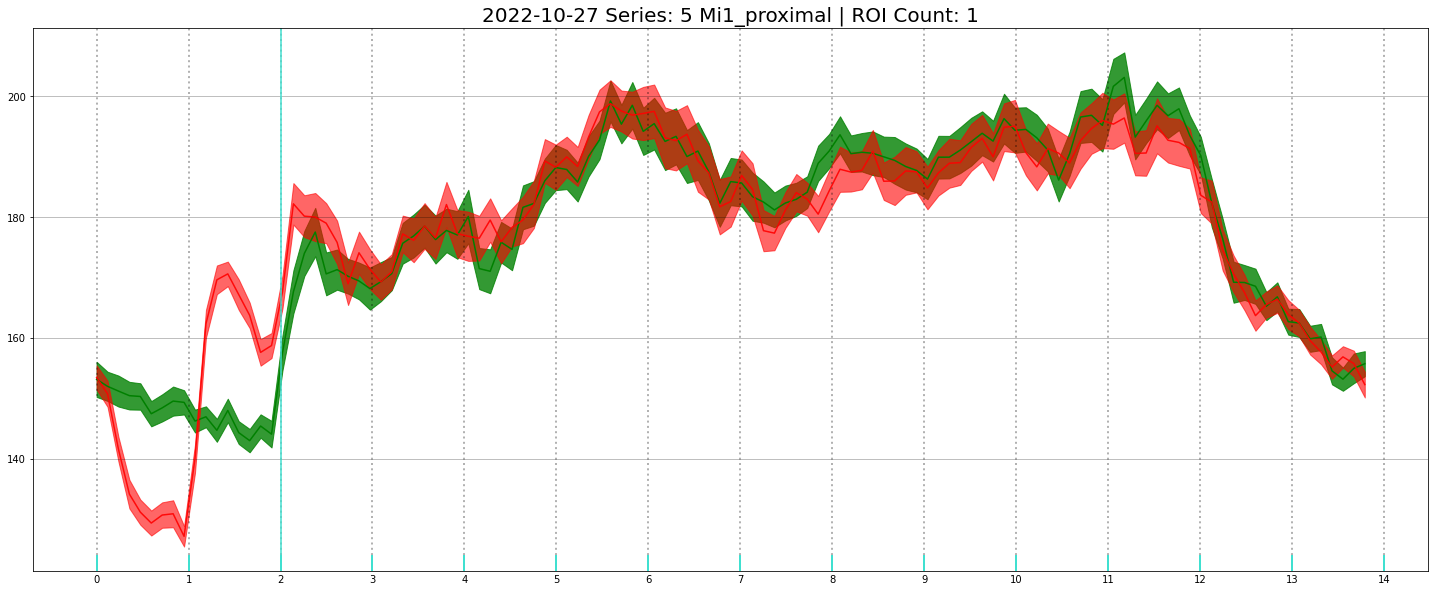

In [31]:
# Collapsing and plotting across ROIs for all expts
# Each experiment is its own plot

save_directory = "/Volumes/ROG2TBAK/data/bruker/raw_specific_cell_types/" #+ experiment_file_name + "/"
print(save_directory)
Path(save_directory).mkdir(exist_ok=True)
# initialize variables
alt_pre_time = 1
df = False
dff = False
saveFig = True

# Loop through experiments and plot it
for exp in range(0, len(expts)):
    print(f'-------Started Experiment {exp+1} of {len(expts)}!-------\n')
    file_path = os.path.join(expts[exp, 0], expts[exp, 1] + ".hdf5")
    ID = imaging_data.ImagingDataObject(file_path, expts[exp, 2], quiet=True)
    roi_data = ID.getRoiResponses(expts[exp, 3])
    
    plotAcrossROIRawSpecificCellType(ID, roi_data, alt_pre_time, 
                                   dff, df, experiment_file_name = expts[exp,1], 
                                   series_number = expts[exp,2], roi_set_name= expts[exp,3])

In [ ]:
def optoSplit(roi_trfs, silent = True):
    # SPLIT into NO Opto and YES Opto trials (alternating)
    no_slice = roi_trfs[:, :, 0::2]  # Every 2 trials, starting at 0
    yes_slice = roi_trfs[:, :, 1::2]  # Every 2 trials, starting at 1

    # compute mean STRF
    # roi_mean_strf = np.mean(roi_strf,3);
    roi_mean_trf = np.mean(roi_trfs, 2)
    nopto_mean_trf = np.mean(no_slice, 2)
    yopto_mean_trf = np.mean(yes_slice, 2)

    # Standard Error of the Mean calculations
    nopto_sem = sem(no_slice, axis=2)  # calculate the no opto sem
    nopto_sem_plus = np.squeeze(nopto_mean_trf + nopto_sem)
    nopto_sem_minus = np.squeeze(nopto_mean_trf - nopto_sem)
    yopto_sem = sem(yes_slice, axis=2)  # calculate the yes opto sem
    yopto_sem_plus = np.squeeze(yopto_mean_trf + yopto_sem)
    yopto_sem_minus = np.squeeze(yopto_mean_trf - yopto_sem)


    if silent == False:
        # Checking ouputs for separating no opto from opto trials
        print("\n----------------------------------------------------------------------------")
        print("----------------------------------------------------------------------------")
        print("||    Checking the shape of the various trfs to ensure opto/no opto split:!")
        print("||    Shape of roi_trfs is: " + str(roi_trfs.shape))
        print("||    Shape of no_slice is: " + str(no_slice.shape))
        print("||    Shape of yes_slice is: " + str(yes_slice.shape))
        print("||")
        print("||    Shape of roi_mean_trf is: " + str(roi_mean_trf.shape))
        print("||    Shape of nopto_mean_trf is: " + str(nopto_mean_trf.shape))
        print("||    Shape of yopto_mean_trf is: " + str(yopto_mean_trf.shape))
        print("----------------------------------------------------------------------------")
        print("----------------------------------------------------------------------------\n")

        print(f'shape of std error is {nopto_sem_plus.shape}')
        
    return (roi_mean_trf, nopto_mean_trf, nopto_sem_plus, nopto_sem_minus, 
            yopto_mean_trf, yopto_sem_plus, yopto_sem_minus
           )

# Function for averaging across ROIs

In [ ]:
def avgAcrossROIs(nopto_mean_trf, nopto_sem_plus, nopto_sem_minus, yopto_mean_trf, yopto_sem_plus, yopto_sem_minus):
    across_roi_nopto_trf = np.mean(nopto_mean_trf, axis = 0)
    across_roi_nopto_sem_plus = np.mean(nopto_sem_plus, axis = 0)
    across_roi_nopto_sem_minus = np.mean(nopto_sem_minus, axis = 0)
    across_roi_yopto_trf = np.mean(yopto_mean_trf, axis = 0)
    across_roi_yopto_sem_plus = np.mean(yopto_sem_plus, axis = 0)
    across_roi_yopto_sem_minus = np.mean(yopto_sem_minus, axis = 0)
    
    return across_roi_nopto_trf, across_roi_nopto_sem_plus, across_roi_nopto_sem_minus, across_roi_yopto_trf, across_roi_yopto_sem_plus, across_roi_yopto_sem_minus


In [ ]:
# Run function to average across ROIs
across_roi_nopto_trf, across_roi_nopto_sem_plus, across_roi_nopto_sem_minus, across_roi_yopto_trf, across_roi_yopto_sem_plus, across_roi_yopto_sem_minus = avgAcrossROIs(nopto_mean_trf, nopto_sem_plus, nopto_sem_minus, yopto_mean_trf, yopto_sem_plus, yopto_sem_minus)

# Filter in Fourier space

In [ ]:
# FFT frequency sample points
def plotFFTFilter(filter_fft, ideal_frame_rate):
    freq = np.fft.fftfreq(n=len(filter_fft), d=1/ideal_frame_rate)

    # Filter power spectrum
    fh, ax = plt.subplots(1, 1, figsize=(6, 3))
    # FFT shift before visualizing
    ax.plot(np.fft.fftshift(freq), np.abs(np.fft.fftshift(filter_fft))**2)
    # ax.plot(np.fft.fftshift(freq), np.fft.fftshift(filter_fft))

    ax.set_xlim([0, 60])
    # ax.set_yscale('log')
    ax.set_xlabel('Freq (Hz)')
    ax.set_ylabel('Power')
    ax.set_title('FFT Filter baby')

    # Conclusion: very little power at high frequencies, no use in doing freq cutoff before ifft

# Everything Below is deprecated!

In [ ]:
print(start_seed)

In [ ]:
# EXPERIMENTAL
# add gray to the pre and post parts of the stimulus 
pre_stim_updates = update_rate*run_parameters["pre_time"]
gray_filler = np.full((int(pre_stim_updates),num_trials), 0.5)

grayed_all_stim = np.concatenate((gray_filler, all_stims, gray_filler), axis=0)